In [1]:
%load_ext autoreload
%autoreload 2

How would you get confidence from TrOCR values? It is fairly simple

In [21]:
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel


def get_processor_and_model(model_name):
    return TrOCRProcessor.from_pretrained(
        model_name
    ), VisionEncoderDecoderModel.from_pretrained(model_name)


model_name = "microsoft/trocr-base-printed"
processor, model = get_processor_and_model(model_name)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


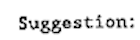

In [11]:
from PIL import Image

img_path = "res/multipage.tiff"
pil_img = Image.open(img_path)
pil_img = pil_img.crop((10, 10, 150, 50))
pil_img = pil_img.convert("RGB")
display(pil_img)


In [22]:
def get_model_output(
    pil_img: Image, processor: TrOCRProcessor, model: VisionEncoderDecoderModel
):
    pixel_values = processor(pil_img, return_tensors="pt").pixel_values
    return model.generate(
        pixel_values, return_dict_in_generate=True, output_scores=True
    )

model_output = get_model_output(pil_img, processor, model)
generated_ids = model_output.sequences
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(f"generated text: '{generated_text}'")


/opt/homebrew/Caskroom/mambaforge/base/envs/py-310/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated text: 'SUGGESTION:'


Take a look at what the generated_ids are.

In [16]:
print(generated_ids)
print(generated_ids.shape)


tensor([[    2,   104, 13644,   534,  4923,  7744,    35,     2]])
torch.Size([1, 8])


The values in the generated_ids are the indices of the vocabulary that have the "highest" score after the softmax layer. To see the output of the model before the final softmax layer, we can look at the scores from the model_output

In [19]:
import numpy as np
scores = model_output.scores
print(type(scores), len(scores))
print(scores[0], scores[0].shape)
print(np.array([score.argmax() for score in scores]))

<class 'tuple'> 7
tensor([[-6.3204, -4.6038,  5.5736,  ..., -7.3016, -7.9567, -5.3557]]) torch.Size([1, 50265])
[  104 13644   534  4923  7744    35     2]


Here, `50_265` is the vocabulary size being used. The generated ids are just the argmaxes. 

To get some measure of how confident the model is of its prediction, we can put these `scores` through the softmax.

In [23]:
import typing as ty
import torch

def get_confidence(scores: ty.Tuple[torch.Tensor]) -> float:
    return np.array([score.softmax(dim=-1).max() for score in scores]).mean()

get_confidence(scores)

0.98754895

Now let's see what happens when we use the handwritten model

In [24]:
model_name = "microsoft/trocr-base-handwritten"
processor, model = get_processor_and_model(model_name)
model_output = get_model_output(pil_img, processor, model)
model_output = get_model_output(pil_img, processor, model)
generated_ids = model_output.sequences
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(f"generated text: '{generated_text}'")
print(get_confidence(model_output.scores))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Caskroom/mambaforge/base/envs/py-310/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated text: 'suggestions.'
0.87509257
